In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<hr>

## Imports

In [8]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import cv2
import os
import zipfile
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import time
import sys

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
import timeit

base_path = pathlib.Path('/content/drive/MyDrive/W207/Data/')
image_dims = (200, 200)

<hr>

## Helper Methods

In [9]:
def timeit(f):
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func:{f.__name__} args:[{args}, {kw}] took: {te-ts:2.4f} sec')        
        return result
    return wrap

<hr>

## Load Data

### From Parquet

In [ ]:
# SKIP
@timeit
def load():
  table = pq.read_table(base_path / 'X_train.pq')
  table = table.to_pandas().to_numpy()
  return table

X_raw = load()
y_raw = np.array(pd.read_csv(base_path / 'X_labels.csv'))

### From Processed PCA

In [10]:
@timeit
def load():
  X_train_process = pd.read_csv(base_path / 'pca_train_data' / 'pca_train.csv')
  X_test_process = pd.read_csv(base_path / 'pca_train_data' / 'pca_test.csv')
  y_train = pd.read_csv(base_path / 'pca_train_data' / 'y_train.csv')
  y_test = pd.read_csv(base_path / 'pca_train_data' / 'y_test.csv')
  return (X_train_process, X_test_process, y_train, y_test)

X_train_process, X_test_process, y_train, y_test = load()

func:load args:[(), {}] took: 9.7703 sec


In [ ]:
# SKIP
print(X_train_process)

                 0            1  ...         500         501
0     -3086.088645 -3501.548528  ...  301.994378  -23.397921
1      3119.128936  -259.044585  ...   -3.365002   53.722091
2     -2572.774611 -3258.021873  ...  -39.405324 -235.345631
3      4356.103444  -715.636869  ...  -31.332249  451.299656
4      3365.437686  -684.422687  ... -246.145311   19.255322
...            ...          ...  ...         ...         ...
69595 -2041.677967   893.256150  ...   49.842376 -108.859648
69596 -2182.808323 -1330.885166  ... -193.557753   27.122280
69597 -1260.622141   231.157133  ...  133.910555 -101.732583
69598 -2875.725420 -3750.581268  ...   14.235476  -46.990548
69599  4022.380638  -917.412920  ...   30.645988  -21.961830

[69600 rows x 502 columns]


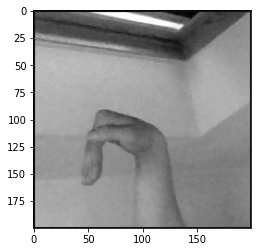

In [ ]:
# SKIP
plt.rc('image', cmap='gray')
plt.imshow(X_raw[5].reshape(*image_dims))
plt.show()

In [ ]:
# SKIP
XF = X_raw[5].reshape(*image_dims)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
mask = np.zeros(XF.shape[:2],np.uint8)
rect = (20, 60, 160, 120)
cv2.grabCut(XF,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = XF*mask2[:,:,np.newaxis]
plt.imshow(img)

<hr>

## Preprocessing 

In [ ]:
# SKIP
def inverse_mask(image, xy, wh, dims):
  x, y = xy
  w, h = wh
  mask = np.zeros(dims, np.uint8)
  mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]
  return mask
  
def preprocess_image(image, dims):
  image = image.reshape(*dims)
  blur_image = cv2.GaussianBlur(image, (7,7), 0)
  edge_image = cv2.Canny(blur_image,10,100)
  mask_image = inverse_mask(edge_image, (20, 60), (160, 120), dims)
  kernel = np.ones((5,5), np.uint8)
  dilate_image = cv2.dilate(mask_image, kernel, iterations=1)
  return dilate_image.reshape(np.product(dims))

X_raw_process = [preprocess_image(i, image_dims) for i in X_raw]

In [ ]:
# SKIP
# Shuffle and split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_raw_process, y_raw, test_size=0.2, random_state=18)  
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, shuffle=False, test_size=0.1)

ValueError: ignored

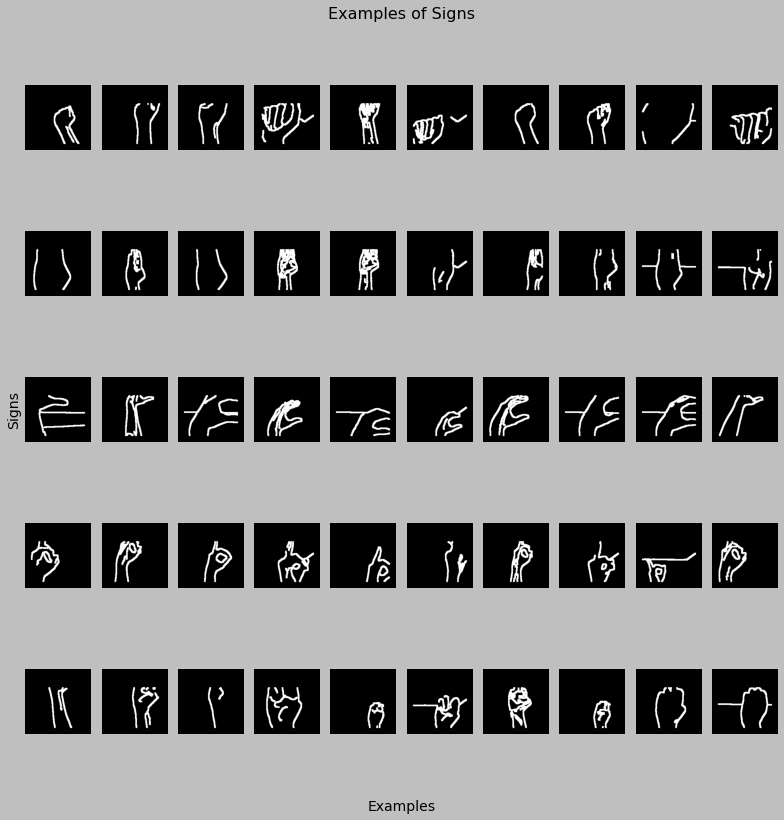

In [ ]:
# SKIP
def show_examples(num_examples=10):
    nrows = 5
    plt.style.use('grayscale')
    fig, axes = plt.subplots(nrows=nrows, ncols=num_examples, sharex=True, sharey=True) 
    fig.set_size_inches(11, 11)
    fig.add_subplot(111, frameon=False)
    
    # Setup grid based on number of digits by number of examples.
    gs = fig.add_gridspec(nrows, num_examples)
    gs.update(wspace=0, hspace=0)
    alpha = ['A', 'B', 'C', 'D', 'E']
    for number in range(nrows):
        # Get a array list of labels for the desired digit.
        labels = np.where(y_train == alpha[number])
        # Select an example up to the number of examples.
        for example in range(num_examples):
            # Reshape to 2d square by dimension and plot.
            axes[number, example].imshow(X_train[labels[0][example]].reshape(*image_dims))
            # Remove individual image axis as they are not useful.
            axes[number, example].axis('off')

    plt.title('Examples of Signs', fontsize=16)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    plt.xlabel("Examples", fontsize=14)
    plt.ylabel("Signs", fontsize=14)
    fig.tight_layout()

show_examples()

In [11]:
def scale(X_train, X_test):
    scaler = sklearn.preprocessing.MinMaxScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_test_transform = scaler.transform(X_test)
    return (X_train_transform, X_test_transform)

X_train_transform, X_test_transform = scale(X_train_process, X_test_process)
print(X_train_transform.shape, X_test_transform.shape)
print(y_train.shape, y_test.shape)

(69600, 502) (17400, 502)
(69600, 1) (17400, 1)


<hr>

## Metrics

In [14]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

inv_labels_dict = {v: k for k, v in labels_dict.items()}

all_labels = list(labels_dict.keys())

# empty list to store model results
model_results = {"model_name":[], "f1_score":[], "accuracy":[], "labels_f1_score":[],"labels_precision":[]}

# Function that returns f1, accuracy, and precision scores
def get_model_metrics(test_data,test_labels, model):
    # predicted labels from test data
    preds = model.predict(test_data)
    # F1 Score
    f1 = metrics.f1_score(test_labels, preds, average='weighted')
    # Accuracy
    accuracy = metrics.accuracy_score(test_labels, preds)
    # Precision
    precision = metrics.precision_score(test_labels, preds, average='weighted')
    
    # Print out scores
    print("******Weighted Metrics********")
    print('    F1-score: {:.4f}\n'.format(f1))
    print('    Accuracy: {:.4f}\n'.format(accuracy))
    print('    Precision: {:.4f}'.format(precision))
    
    # get scores for each label
    f1_l = metrics.f1_score(test_labels, preds, average=None)
    precision_l = metrics.precision_score(test_labels, preds, average=None)
    
    # Print out scores
    print("\n******Per-label Metrics********")
    print("F1 score:")
    print(f1_l)
    print("Precision:")
    print(precision_l)
    
    return f1, accuracy, precision, f1_l, precision_l

<hr>

## Naive Bayes

In [16]:
def score_summary(data, columns, label):
    # Create a dataframe for pretty printing with the help of pandas.
    pd.options.display.float_format = None
    data_frame = pd.DataFrame(data, columns=columns)
    for k in ['f1_score', 'mean_accuracy', 'ss_weights']:
        if k in data_frame:
            data_frame[k] = data_frame[k].map('{:.4f}'.format)
    print(label)
    print(data_frame.T.to_string(index=True, header=False))
    return data_frame
    
# Find the optimum score within scores and print.
def print_optimum(scores, fstring):
    max_score = (0, 0)
    for score in scores:     
        if score[1] > max_score[1]:
            max_score = score
    print('Optimum: ', fstring.format(*max_score), '\n')
    return max_score

# Using the Multinomial Naive Bayes, fit and predict, and generate f1 score.
def mnb_score(alpha, train_vectors, train_labels, dev_vectors, dev_labels, save=False):
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(train_vectors, train_labels)
    dev_pred = clf.predict(dev_vectors)
    score = metrics.f1_score(dev_labels, dev_pred, average='weighted')
    mean_accuracy = clf.score(dev_vectors, dev_labels)
    #storing model metrics for best performing alpha value
    if save:
        f1, accuracy, precision, f1_l, precision_l = get_model_metrics(dev_vectors, dev_labels, clf)
        model_results["model_name"].append("MultinomialNB")
        model_results["f1_score"].append(f1)
        model_results["accuracy"].append(accuracy)
        model_results["labels_f1_score"].append(f1_l)
        model_results["labels_precision"].append(precision_l)
        return clf

    # acc = accuracy(dev_pred, dev_labels)
    return (alpha, score, mean_accuracy)
# various alpha values to iterate through
alpha = [1.0e-10, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0, 100.0, 200.0, 500.0]
scores = [mnb_score(a, X_train_transform, np.ravel(y_train), X_test_transform, np.ravel(y_test)) for a in alpha]
scores_df = score_summary(scores, columns=['alpha', 'f1_score', 'mean_accuracy'], label='Naive Bayes models')
max_score = print_optimum(scores, 'alpha={0} f1_score={1:.4f} mean_accuracy={2:.4f}')

mnb = mnb_score(max_score[0], X_train_transform, np.ravel(y_train), X_test_transform, np.ravel(y_test), save=True)

Naive Bayes models
alpha           1e-10   1e-06   1e-05  0.0001   0.001    0.01    0.07     0.1     0.2     0.3     0.4     0.5       1     1.5       2    2.25     2.5       3     3.5       4       5      10     100     200     500
f1_score       0.6721  0.6721  0.6721  0.6721  0.6721  0.6721  0.6721  0.6721  0.6720  0.6720  0.6720  0.6720  0.6719  0.6720  0.6719  0.6719  0.6720  0.6720  0.6720  0.6719  0.6716  0.6714  0.6670  0.6640  0.6479
mean_accuracy  0.6699  0.6699  0.6699  0.6699  0.6699  0.6699  0.6699  0.6699  0.6698  0.6698  0.6698  0.6698  0.6698  0.6699  0.6698  0.6698  0.6698  0.6698  0.6699  0.6698  0.6695  0.6694  0.6655  0.6630  0.6482
Optimum:  alpha=1e-10 f1_score=0.6721 mean_accuracy=0.6699 

******Weighted Metrics********
    F1-score: 0.6721

    Accuracy: 0.6699

    Precision: 0.6970

******Per-label Metrics********
F1 score:
[0.64091308 0.61046907 0.58350515 0.62734082 0.74339301 0.75510204
 0.71037464 0.72954925 0.64335664 0.6433121  0.64412238 0.6828812
 0.65

(2.0, 0.6829642795924487, 0.6814942528735632)


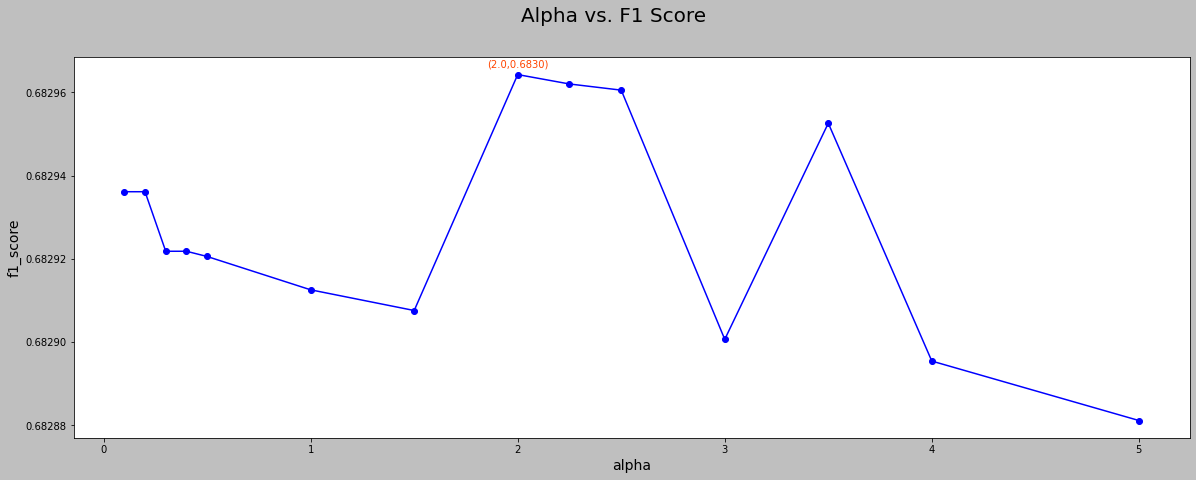

In [ ]:
def plot_sub_metrics(ax, df, x_name, y_name, optimum, **kwargs):
    ax.plot(df[x_name], df[y_name], **kwargs)
    # for x, y in zip(df[x_name], df[y_name]):
    #     label = f"({x},{y})"
    print(optimum)
    plt.annotate("({0},{1:.4f})".format(*optimum[:2]), optimum[:2], textcoords="offset points", xytext=(0,7), ha='center', color='orangered')
    ax.set_xlabel(x_name, fontsize=14)
    ax.set_ylabel(y_name, fontsize=14)

def plot_metrics(sub_scores_df):
    fig = plt.figure(figsize=(20,7)) 
    fig.suptitle('Alpha vs. F1 Score', fontsize=20)
    ax = fig.subplots()   
    plot_sub_metrics(ax, sub_scores_df, 'alpha', 'f1_score', optimum=optimum, color='blue', marker='o', label='f1 score',)
    # ax_twin = ax.twinx()
    # plot_sub_metrics(ax_twin, sub_scores_df, 'alpha', 'mean_accuracy', color='darkblue', marker='d', label='accuracy')
    # plot_sub_metrics(ax[1], sub_scores_df, 'alpha', 'mean_accuracy', color='darkblue', marker='d', label='accuracy')
    # ax.set_xlabel('Alpha', fontsize=14)
    # ax.set_ylabel('F1 Score', fontsize=14, color='blue')
    # ax_twin.set_ylabel('Accuracy', fontsize=14, color='darkblue')
    # fig.legend()

plot_metrics(scores_df[(scores_df['alpha'] <= 5) & (scores_df['alpha'] >= 0.1)])

<hr>

## Logistic Regression

<hr>

## Convolutional Neural Networks